Gradient Boosting Regressor R² Score on Test Set with Clustering: 0.96
Gradient Boosting Stratified Cross-validated R² scores with Clustering: [0.95860533 0.95616881 0.95903957 0.95767644 0.96125911]
Mean Gradient Boosting Cross-validated R² score with Clustering: 0.96
Predicted Demand Scores for Sample Facilities using Gradient Boosting with Clustering: [ 5.2600578   5.2600578  17.73638287 31.50394363 10.61516589]
Models saved at:
- Gradient Boosting Regressor: healthcare_connectivity_model.pkl
- Scaler: scaler_with_clustering.pkl
- KMeans: kmeans_with_clustering.pkl


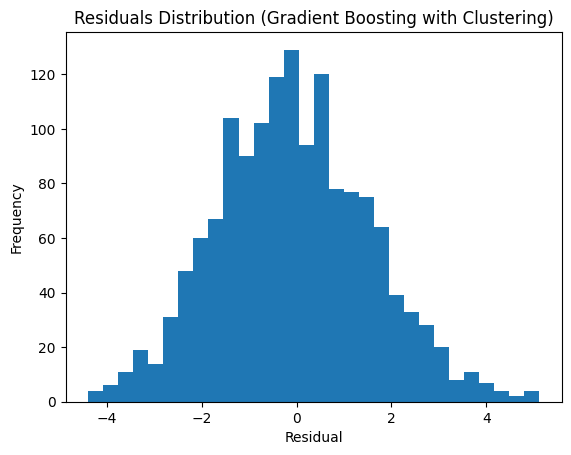

In [9]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
import matplotlib.pyplot as plt

file_path = '/content/healthcare-connectivity-dataset.csv'
data = pd.read_csv(file_path)

data = data.dropna(subset=['Latitude', 'Longitude'])

data['Facility_Owner_Encoded'] = data['Facility_Owner'].astype('category').cat.codes
data['Facility_Type_Encoded'] = data['Renamed_Facility_Type'].astype('category').cat.codes

scaler = StandardScaler()
data[['Latitude_Scaled', 'Longitude_Scaled']] = scaler.fit_transform(data[['Latitude', 'Longitude']])

kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['Latitude_Scaled', 'Longitude_Scaled']])

data['Demand_Score'] = (
    data['Facility_Type_Encoded'] * 1.2 +
    data['Facility_Owner_Encoded'] * 0.5 +
    data['Cluster'] * 1.5 +
    np.random.normal(0, 1.5, size=len(data)) +
    data['Latitude_Scaled'] * 1.0 +
    data['Longitude_Scaled'] * 1.0
)

data['Interaction_Term'] = data['Latitude_Scaled'] * data['Longitude_Scaled']

features = ['Latitude_Scaled', 'Longitude_Scaled', 'Facility_Type_Encoded',
            'Facility_Owner_Encoded', 'Cluster', 'Interaction_Term']
target = 'Demand_Score'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gbr = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gbr.fit(X_train, y_train)

gbr_score = gbr.score(X_test, y_test)
print(f"Gradient Boosting Regressor R² Score on Test Set with Clustering: {gbr_score:.2f}")

y_binned = pd.cut(y, bins=5, labels=False)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gbr_cv_scores = cross_val_score(gbr, X, y, cv=stratified_kfold.split(X, y_binned), scoring='r2')
print(f"Gradient Boosting Stratified Cross-validated R² scores with Clustering: {gbr_cv_scores}")
print(f"Mean Gradient Boosting Cross-validated R² score with Clustering: {np.mean(gbr_cv_scores):.2f}")

gbr_predicted_demand = gbr.predict(X_test[:5])
print("Predicted Demand Scores for Sample Facilities using Gradient Boosting with Clustering:", gbr_predicted_demand)

gbr_model_path = 'healthcare_connectivity_model.pkl'
scaler_model_path = 'scaler_with_clustering.pkl'
kmeans_model_path = 'kmeans_with_clustering.pkl'

joblib.dump(gbr, gbr_model_path)
joblib.dump(scaler, scaler_model_path)
joblib.dump(kmeans, kmeans_model_path)

print(f"Models saved at:\n- Gradient Boosting Regressor: {gbr_model_path}\n- Scaler: {scaler_model_path}\n- KMeans: {kmeans_model_path}")

gbr_residuals = y_test - gbr.predict(X_test)
plt.hist(gbr_residuals, bins=30)
plt.title("Residuals Distribution (Gradient Boosting with Clustering)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()
